In [1]:
import gc

import pandas as pd
import  mbr_kernel as mkn
import numpy as np
import utilitaires_810 as u810

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'

# ---------------------------------------------------------------- MAKE SCRORER
def compute_F2(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

def compute_F2_custom(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.1 * faux_pos + faux_negs)
    return f2_score

F2_score = make_scorer(compute_F2, greater_is_better=True)
F2custom_score = make_scorer(compute_F2_custom, greater_is_better=True)


In [2]:
def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5, do_under=True) :
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    if do_under :
        under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    if do_under :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("under", under),
            ("estimator", estimator)
        ])
    else :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("estimator", estimator)
        ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}

def transform_X(X):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


# PREPARE DATA

In [3]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 17)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 7s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 22s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 14s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)


# TEST MODEL

In [4]:
# model_and_res = test_model(df,estimator=xgb.XGBClassifier(), confusion=True)

In [35]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = xgb.XGBClassifier(gamma=0.1, max_depth=6, subsample=0.2, n_estimators=500, colsample_bytree=0.5, learning_rate=0.05)

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__min_child_weight' : [500, 800, 1000],
    'estimator__scale_pos_weight' : [1, 4, 9, 12]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=F2_score,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

model.fit(X_train, y_train)

model

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=No...
                                                      max_depth=6,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'estimator__min_child_weight': [500, 800, 1000],
                         'estimator__scale_pos_weight': [1, 4, 9, 12]},
             return_train_score=True, scoring=make_scorer(compute_F2),
             verbose=2)

5 minutes pour 135 fits !

In [36]:
model.best_params_

{'estimator__min_child_weight': 500, 'estimator__scale_pos_weight': 4}

In [33]:
model.best_score_

0.4177154455289315

xgb.XGBClassifier(gamma = 0.1, max_depth=6, n_estimators=100, learning_rate=0.1, colsample_bytree=0.5, subsample=0.2)
xgb.XGBClassifier(gamma = 0.1, max_depth=6, n_estimators=500, learning_rate=0.05, colsample_bytree=0.5, subsample=0.2, min_child_weight=50)

PREPARING MODEL
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.3836108280297764
TRAIN F2Custom score 0.5285057439201848
TRAIN AUC 0.6755397562094185
TRAIN Recall 0.8711778680358648
TEST F2 score 0.37687695797774656
TEST F2Custom score 0.5186864650894832
TEST AUC 0.6673058881756332
TEST Recall 0.8556100551808706


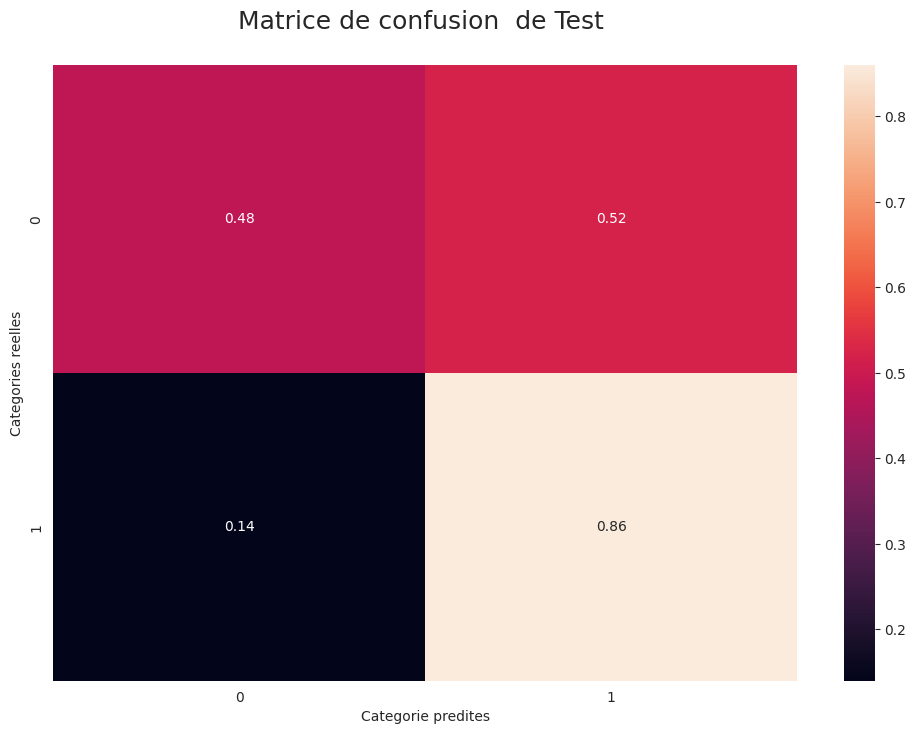

In [37]:
estimator = xgb.XGBClassifier(gamma = 0.1, max_depth=6, n_estimators=500, learning_rate=0.05, colsample_bytree=0.5, subsample=0.2, min_child_weight=500, scale_pos_weight=4)
dict_res = test_model(df, estimator=estimator, confusion=True)

# Comment obtenir 0.97 TP ?!
Sans under sampling,
Avec une grid search positionnee sur la F2 Custom, XGBoost propose le modele suivant :
xgb.XGBClassifier(gamma = 0.1, max_depth=6, n_estimators=500, learning_rate=0.05, colsample_bytree=0.5, subsample=0.2, min_child_weight=500, scale_pos_weight=11)

Il a 0.97 de TP !! Mais 0.82 FP...

TEST F2 score 0.3170211481578365
TEST F2Custom score 0.4765721891164282


# Best so far
Avec under sampling par defaut,
estimator = xgb.XGBClassifier(gamma = 0.1, max_depth=6, n_estimators=500, learning_rate=0.05, colsample_bytree=0.5, subsample=0.2, min_child_weight=500, scale_pos_weight=4)

0.86 TP et 0.52 FP
